In [1]:
import librosa
import librosa.display
import soundfile
import seaborn as sns
import os, glob, pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn



# Duyguların Tanımı

In [2]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}


#Izlenecek duygular
observed_emotions=['happy', 'angry', 'surprised','sad']

# Fonksiyonlar

### Ses Bilgi Alma Fonksiyonları

In [3]:
#chroma : Müziğin armonik ve melodik özelliklerini yakalar (tınısını).
def get_chroma(file_name):
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        stft=np.abs(librosa.stft(X))
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=100).T,axis=0)
    return chroma

#mfcc : Ses işlemede, mel-frekanslı cepstrum, bir sesin kısa süreli güç spektrumunun, doğrusal olmayan bir erime 
#       frekans ölçeğindeki bir log güç spektrumunun doğrusal bir kosinüs dönüşümüne dayanan bir temsilidir. 
#       Mel-frekanslı cepstral katsayıları, toplu olarak bir MFC oluşturan katsayılardır.
def get_mfcc(file_name):
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        mfcc=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=128 ).T, axis=0)
    return mfcc

#mel : Mel Spectrogram Frequency frekansların mel ölçeğine dönüştürüldüğü bir spektrogramdır.
def get_mel(file_name):
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
    return mel

#zero-cross-rate:ses genliğinin sıfırı aşma oranı
def get_zcros(file_name):
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        zcros=np.mean(librosa.feature.zero_crossing_rate(X).T, axis=0)
    return zcros[0]

#spectral roll off:Bu, güç spektrumunun sağa çarpıklık miktarının bir ölçüsüdür. 
#                  Spektral yuvarlanma noktası, gücün% 85'inin daha düşük frekanslarda olduğu güç spektrumundaki bölmelerin fraksiyonudur.
def get_spectralRoff(file_name):
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        stft,phase=librosa.magphase(librosa.stft(X))
        spectralRoff=np.mean(librosa.feature.spectral_rolloff(S=stft, sr=sample_rate).T, axis=0)
    return spectralRoff

#spectral flux:Frekans boyunca toplanan spektral büyüklük vektörünün kareden kareye kare farkıdır.
def get_spectralFlux(file_name):
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        spectralFlux=np.mean(librosa.onset.onset_strength(y=X,sr=sample_rate))
    return spectralFlux

#pitch:Ses perdesidir,yani bir dinleyicinin müzikal tonları,
#          öncelikle titreşim frekansına ilişkin algılarına dayalı olarak müzikal bir ölçekte göreceli konumlara atadığı işitsel bir duygudur
def get_pitch(file_name):
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        pitch=np.mean(librosa.piptrack(y=X, sr=sample_rate))
    return pitch




In [4]:
help(librosa.feature.melspectrogram)

Help on function melspectrogram in module librosa.feature.spectral:

melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='reflect', power=2.0, **kwargs)
    Compute a mel-scaled spectrogram.
    
    If a spectrogram input ``S`` is provided, then it is mapped directly onto
    the mel basis by ``mel_f.dot(S)``.
    
    If a time-series input ``y, sr`` is provided, then its magnitude spectrogram
    ``S`` is first computed, and then mapped onto the mel scale by
    ``mel_f.dot(S**power)``.
    
    By default, ``power=2`` operates on a power spectrum.
    
    Parameters
    ----------
    y : np.ndarray [shape=(n,)] or None
        audio time-series
    
    sr : number > 0 [scalar]
        sampling rate of ``y``
    
    S : np.ndarray [shape=(d, t)]
        spectrogram
    
    n_fft : int > 0 [scalar]
        length of the FFT window
    
    hop_length : int > 0 [scalar]
        number of samples between succes

In [5]:
help(librosa.onset.onset_strength)

Help on function onset_strength in module librosa.onset:

onset_strength(y=None, sr=22050, S=None, lag=1, max_size=1, ref=None, detrend=False, center=True, feature=None, aggregate=None, **kwargs)
    Compute a spectral flux onset strength envelope.
    
    Onset strength at time ``t`` is determined by::
    
        mean_f max(0, S[f, t] - ref[f, t - lag])
    
    where ``ref`` is ``S`` after local max filtering along the frequency
    axis [#]_.
    
    By default, if a time series ``y`` is provided, S will be the
    log-power Mel spectrogram.
    
    .. [#] Böck, Sebastian, and Gerhard Widmer.
           "Maximum filter vibrato suppression for onset detection."
           16th International Conference on Digital Audio Effects,
           Maynooth, Ireland. 2013.
    
    Parameters
    ----------
    y        : np.ndarray [shape=(n,)]
        audio time-series
    
    sr       : number > 0 [scalar]
        sampling rate of ``y``
    
    S        : np.ndarray [shape=(d, m)]
   

### Kolon Adı Türetme Fonksiyonları

In [6]:
def get_mfcc_columns(len):
    list = []
    for i in range(len):
        list.append("mfcc_" + str(i+1))
    return list

def get_chroma_columns(len):
    list = []
    for i in range(len):
        list.append("chroma_" + str(i+1))
    return list

def get_mel_columns(len):
    list = []
    for i in range(len):
        list.append("mel_" + str(i+1))
    return list

### Normalizasyon fonksiyonu

In [7]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

### Verileri Yükleme Fonksiyonu

In [8]:
def load_data():
    
    listFeatureMfcc=[]
    listFeatureChroma=[]
    listFeatureMel=[]
    listFeatureZcros=[]
    listFeatureSpectralRoff=[]
    listFeatureSpectralFlux=[]
    listFeaturePitch=[]
    listFeatureEmotions=[]

    for file in glob.glob("data\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions: 
            continue
        
        featureMfcc=get_mfcc(file)
        featureChroma=get_chroma(file)
        featureMel=get_mel(file)
        featureZcros=get_zcros(file)
        featureSpectralRoff=get_spectralRoff(file)
        featureSpectralFlux=get_spectralFlux(file)
        featurePitch=get_pitch(file)
        
        
        listFeatureMfcc.append(featureMfcc)
        listFeatureChroma.append(featureChroma)
        listFeatureMel.append(featureMel)
        listFeatureZcros.append(featureZcros)
        listFeatureSpectralRoff.append(featureSpectralRoff)
        listFeatureSpectralFlux.append(featureSpectralFlux)
        listFeaturePitch.append(featurePitch)
        listFeatureEmotions.append(emotion)
        
    df_mfcc = pd.DataFrame(listFeatureMfcc,columns=get_mfcc_columns(len(featureMfcc)))
    df_mfcc_normalized=normalize(df_mfcc)
    
    df_chroma = pd.DataFrame(listFeatureChroma,columns=get_chroma_columns(len(featureChroma)))
    df_chroma_normalized=normalize(df_chroma)
    
    df_mel = pd.DataFrame(listFeatureMel,columns=get_mel_columns(len(featureMel)))
    df_mel_normalized=normalize(df_mel)
    
    df_zcros=pd.DataFrame(listFeatureZcros,columns=['zcros'])
    df_zcros_normalized=normalize(df_zcros)
    
    df_spectralRoff=pd.DataFrame(listFeatureSpectralRoff,columns=['spectralRoff'])
    df_spectralRoff_normalized=normalize(df_spectralRoff)
    
    df_spectralFlux=pd.DataFrame(listFeatureSpectralFlux,columns=['spectralFlux'])
    df_spectralFlux_normalized=normalize(df_spectralFlux)
    
    df_pitch=pd.DataFrame(listFeaturePitch,columns=['pitch'])
    df_pitch_normalized=normalize(df_pitch)
    
    df_emotions=pd.DataFrame(listFeatureEmotions,columns=['emotions'])
    
    df=pd.concat([df_mfcc_normalized,
                  df_chroma_normalized,
                  df_mel_normalized,
                  df_zcros_normalized,
                  df_spectralRoff_normalized,
                  df_spectralFlux_normalized,
                  df_pitch_normalized,
                  df_emotions],axis=1)
    #df=pd.concat([df_mfcc,df_chroma,df_mel,df_zcros,df_spectralRoff,df_emotions],axis=1)
    
    return df


# Veriyi Getirme ve Gösterme

In [9]:
df=load_data()

A:\anaconda3\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [10]:
df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mel_124,mel_125,mel_126,mel_127,mel_128,zcros,spectralRoff,spectralFlux,pitch,emotions
0,0.358925,0.662308,0.611102,0.621880,0.637577,0.565024,0.554374,0.505060,0.533128,0.648071,...,0.000253,0.000507,0.000437,0.000294,0.000214,0.119783,0.700600,0.182074,0.672588,happy
1,0.396615,0.644996,0.607544,0.678506,0.705465,0.547804,0.609683,0.477004,0.537776,0.742332,...,0.000151,0.000412,0.000638,0.000364,0.000330,0.066035,0.658779,0.156227,0.610486,happy
2,0.336970,0.653802,0.653552,0.568844,0.652327,0.610560,0.529649,0.444942,0.491217,0.809955,...,0.000591,0.000832,0.001184,0.000551,0.000332,0.168104,0.692406,0.191432,0.725921,happy
3,0.350124,0.600206,0.710609,0.678337,0.637338,0.670380,0.591421,0.446234,0.480448,0.719960,...,0.000699,0.002618,0.002708,0.001973,0.000989,0.178334,0.715934,0.300031,0.489383,happy
4,0.447214,0.545509,0.589539,0.420485,0.623245,0.518049,0.355510,0.568560,0.314912,0.669408,...,0.000877,0.001936,0.002747,0.001585,0.001965,0.235571,0.612133,0.246523,0.670107,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.466847,0.309467,0.453088,0.196201,0.303421,0.406208,0.122748,0.608272,0.466881,0.316868,...,0.006570,0.011561,0.019265,0.012176,0.009530,0.443137,0.628753,0.347715,0.597096,surprised
764,0.566048,0.437057,0.442449,0.143872,0.257897,0.407956,0.366824,0.537538,0.581050,0.310155,...,0.009303,0.018167,0.029046,0.021810,0.026948,0.440256,0.598453,0.547059,0.592852,surprised
765,0.543248,0.363137,0.411093,0.224649,0.208120,0.321127,0.337789,0.567814,0.668354,0.431102,...,0.005988,0.008801,0.015402,0.013334,0.010427,0.480377,0.546739,0.503487,0.680691,surprised
766,0.627746,0.340656,0.602132,0.279525,0.421491,0.553870,0.342848,0.821939,0.577649,0.459242,...,0.121322,0.305571,0.460412,0.333689,0.244313,0.564427,0.614379,0.418981,0.386245,surprised


# Verinin İncelenmesi

In [11]:
df.columns

Index(['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10',
       ...
       'mel_124', 'mel_125', 'mel_126', 'mel_127', 'mel_128', 'zcros',
       'spectralRoff', 'spectralFlux', 'pitch', 'emotions'],
      dtype='object', length=361)

In [12]:
#dfmel=pd.DataFrame(get_mel("data\\Actor_05\\03-01-01-01-01-02-05.wav"))
#dfmelnormalize=normalize(dfmel)
#sns.heatmap(dfmelnormalize)

In [13]:
count_mfcc = 0
count_chroma = 0
count_mel = 0
for item in df.columns:
    if("mfcc_" in item) : count_mfcc += 1
    elif("chroma_" in item) : count_chroma += 1
    elif("mel_" in item) : count_mel += 1
        
print("Mfcc Sayısı : " + str(count_mfcc))
print("Chroma Sayısı : " + str(count_chroma))
print("Mel Sayısı : " + str(count_mel))
print("Toplam Girdi Kolonu Sayısı : " + str(count_mfcc + count_chroma + count_mel +4))

Mfcc Sayısı : 128
Chroma Sayısı : 100
Mel Sayısı : 128
Toplam Girdi Kolonu Sayısı : 360


In [14]:
df["emotions"].unique()

array(['happy', 'sad', 'angry', 'surprised'], dtype=object)

In [15]:
df.corr()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mel_123,mel_124,mel_125,mel_126,mel_127,mel_128,zcros,spectralRoff,spectralFlux,pitch
mfcc_1,1.000000,-0.601620,-0.628196,-0.462361,-0.503146,-0.374246,-0.091039,-0.354408,-0.209894,-0.110234,...,0.558226,0.486013,0.563868,0.581635,0.544914,0.545600,0.619706,0.094930,0.345362,0.119240
mfcc_2,-0.601620,1.000000,0.694133,0.777354,0.792804,0.463719,0.381417,0.371607,0.209278,0.412537,...,-0.410451,-0.347287,-0.394369,-0.395846,-0.388763,-0.389874,-0.542390,-0.198884,-0.076438,-0.523196
mfcc_3,-0.628196,0.694133,1.000000,0.523914,0.727289,0.662199,0.436218,0.555716,0.068766,0.446946,...,-0.251301,-0.217646,-0.235778,-0.239319,-0.241331,-0.234266,-0.602426,-0.038327,-0.314972,-0.527890
mfcc_4,-0.462361,0.777354,0.523914,1.000000,0.700955,0.422396,0.488668,0.354367,0.409262,0.344185,...,-0.282999,-0.216633,-0.265319,-0.276576,-0.258154,-0.283227,-0.381821,-0.117016,-0.061258,-0.444271
mfcc_5,-0.503146,0.792804,0.727289,0.700955,1.000000,0.507346,0.546368,0.393518,0.182524,0.599976,...,-0.235086,-0.184262,-0.213655,-0.227704,-0.220859,-0.240968,-0.560704,-0.028022,-0.258436,-0.578559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mel_128,0.545600,-0.389874,-0.234266,-0.283227,-0.240968,-0.149357,-0.018362,-0.117026,-0.150576,-0.027818,...,0.839121,0.783416,0.844058,0.908014,0.929669,1.000000,0.406399,0.174817,0.190838,0.086023
zcros,0.619706,-0.542390,-0.602426,-0.381821,-0.560704,-0.489769,-0.481179,-0.405202,-0.039008,-0.406620,...,0.408454,0.342040,0.398067,0.410045,0.380682,0.406399,1.000000,0.252923,0.537210,0.399584
spectralRoff,0.094930,-0.198884,-0.038327,-0.117016,-0.028022,-0.043217,0.027092,-0.094218,-0.011145,0.053473,...,0.161592,0.144254,0.157502,0.147414,0.160043,0.174817,0.252923,1.000000,0.020716,0.156704
spectralFlux,0.345362,-0.076438,-0.314972,-0.061258,-0.258436,-0.318544,-0.330342,-0.254839,-0.096001,-0.167707,...,0.183282,0.124919,0.154335,0.170805,0.170367,0.190838,0.537210,0.020716,1.000000,0.158483


### Örnek Veri

In [16]:
x, sr = librosa.load("data\\Actor_03\\03-01-01-01-02-01-03.wav")
ipd.Audio(x, rate=sr)

In [17]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

(151,)

In [18]:
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

In [19]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

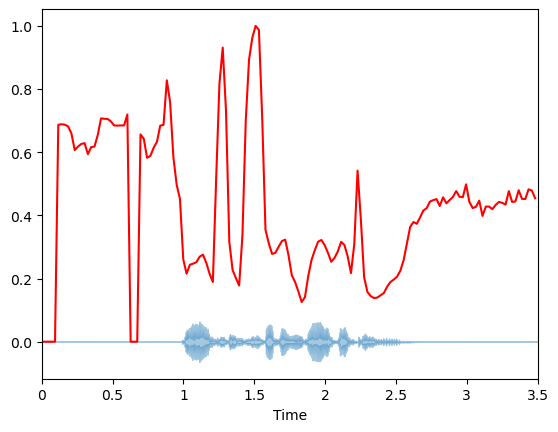

In [20]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

<AxesSubplot:>

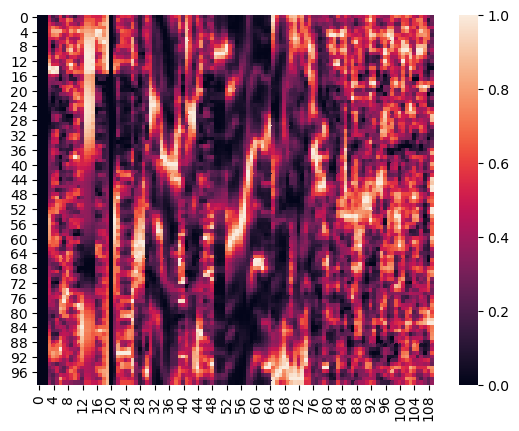

In [21]:

with soundfile.SoundFile("data\\Actor_03\\03-01-01-01-02-01-03.wav") as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    stft=np.abs(librosa.stft(X))
    chroma=librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=100)
df_chroma_data=pd.DataFrame(chroma)
df_chroma_data_normalized=normalize(df_chroma_data)
sns.heatmap(df_chroma_data_normalized)
  

<AxesSubplot:title={'center':'mfcc'}>

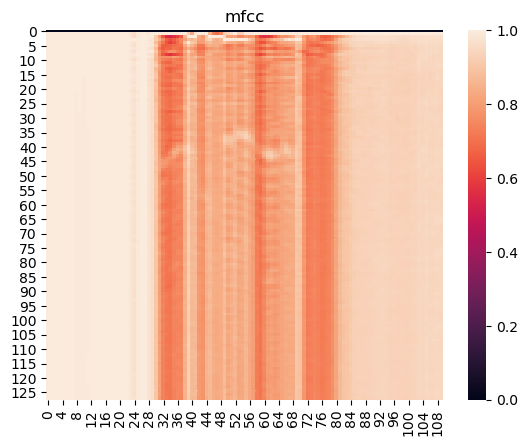

In [22]:
with soundfile.SoundFile("data\\Actor_03\\03-01-01-01-02-01-03.wav") as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        mfcc=librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=128 )
df_mfcc_data=pd.DataFrame(mfcc)
df_mfcc_data_normalized=normalize(df_mfcc_data)
plt.title("mfcc")
sns.heatmap(df_mfcc_data_normalized)    

<AxesSubplot:>

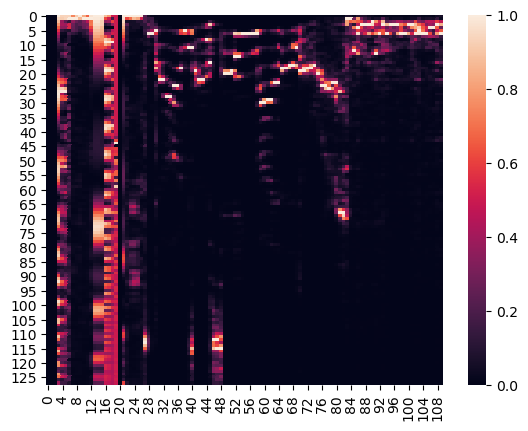

In [79]:
with soundfile.SoundFile("data\\Actor_03\\03-01-01-01-02-01-03.wav") as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        mel=librosa.feature.melspectrogram(y=X, sr=sample_rate)
df_mel_data=pd.DataFrame(mel)
df_mel_data_normalized=normalize(df_mel_data)
sns.heatmap(df_mel_data_normalized)   

# Verilerin Model İçin Hazırlanması

In [24]:
df["emotions"].replace({
    "happy":1,
    "angry":2,
    "surprised":3,
    "sad":4
}, inplace = True)


x = df.iloc[:,:-1].values
y = df.iloc[:,len(df.columns)-1].values
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=21)

# Model Eğitimi

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


In [26]:
model_mlp = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model_knn = KNeighborsClassifier(n_neighbors=8)
model_naivebayes = GaussianNB()
model_decisiontree = DecisionTreeClassifier()

In [27]:
#Training model (mlp)
model_mlp.fit(x_train,y_train)


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [28]:
#Training model (knn)
model_knn.fit(x_train,y_train)


KNeighborsClassifier(n_neighbors=8)

In [29]:
#Training model (naive bayes)
model_naivebayes.fit(x_train,y_train)


GaussianNB()

In [30]:
#Training model (decision tree)
model_decisiontree.fit(x_train,y_train)


DecisionTreeClassifier()

# Model Test

In [31]:
y_pred_mlp = model_mlp.predict(x_test)

y_pred_knn = model_knn.predict(x_test)

y_pred_naivebayes = model_naivebayes.predict(x_test)

y_pred_decisiontree = model_decisiontree.predict(x_test)

# Confusion Matrix

In [32]:
con_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

con_matrix_knn = confusion_matrix(y_test, y_pred_knn)

con_matrix_nb = confusion_matrix(y_test, y_pred_naivebayes)

con_matrix_tree = confusion_matrix(y_test, y_pred_decisiontree)


# Sonuçlar

In [33]:
mlp_abs_err = metrics.mean_absolute_error(y_test,y_pred_mlp)
mlp_sqr_err = metrics.mean_squared_error(y_test,y_pred_mlp)

knn_abs_err = metrics.mean_absolute_error(y_test,y_pred_knn)
knn_sqr_err = metrics.mean_squared_error(y_test,y_pred_knn)

naive_abs_err =metrics.mean_absolute_error(y_test,y_pred_naivebayes)
naive_sqr_err =metrics.mean_squared_error(y_test,y_pred_naivebayes)

tree_abs_err =metrics.mean_absolute_error(y_test,y_pred_decisiontree)
tree_sqr_err =metrics.mean_squared_error(y_test,y_pred_decisiontree)

print("MLP")
print("--------")
mlp_sensitivity = con_matrix_mlp[0][0]/(con_matrix_mlp[0][0] + sum(con_matrix_mlp[1:4,0]))
mlp_specificity = sum(sum(con_matrix_mlp[1:4,1:4]))/(sum(sum(con_matrix_mlp[1:4,1:4])) + sum(con_matrix_mlp[0,1:4]))
print("\n")

print(classification_report(y_test,y_pred_mlp))


print("\n")



print("\n")

print("KNN") 
print("--------")
knn_sensitivity = con_matrix_knn[0][0]/(con_matrix_knn[0][0] + sum(con_matrix_knn[1:4,0]))
knn_specificity = sum(sum(con_matrix_knn[1:4,1:4]))/(sum(sum(con_matrix_knn[1:4,1:4])) + sum(con_matrix_knn[0,1:4]))
print("\n")

print(classification_report(y_test,y_pred_knn))


print("\n")



print("\n")

print("Naive Bayes") 
print("--------")
naivebayes_sensitivity = con_matrix_nb[0][0]/(con_matrix_nb[0][0] + sum(con_matrix_nb[1:4,0]))
naivebayes_specificity = sum(sum(con_matrix_nb[1:4,1:4]))/(sum(sum(con_matrix_nb[1:4,1:4])) + sum(con_matrix_nb[0,1:4]))
print("\n")

print(classification_report(y_test,y_pred_naivebayes))


print("\n")



print("\n")

print("Decision Tree") 
print("--------")

tree_sensitivity = con_matrix_tree[0][0]/(con_matrix_tree[0][0] + sum(con_matrix_tree[1:4,0]))
tree_specificity = sum(sum(con_matrix_tree[1:4,1:4]))/(sum(sum(con_matrix_tree[1:4,1:4])) + sum(con_matrix_tree[0,1:4]))
print("\n")

print(classification_report(y_test,y_pred_decisiontree))


print("\n")



print("\n")


MLP
--------


              precision    recall  f1-score   support

           1       0.71      0.69      0.70        51
           2       0.87      0.73      0.79        55
           3       0.60      0.82      0.69        38
           4       0.84      0.79      0.82        48

    accuracy                           0.75       192
   macro avg       0.76      0.76      0.75       192
weighted avg       0.77      0.75      0.75       192





KNN
--------


              precision    recall  f1-score   support

           1       0.52      0.53      0.52        51
           2       0.62      0.56      0.59        55
           3       0.33      0.63      0.43        38
           4       0.82      0.29      0.43        48

    accuracy                           0.50       192
   macro avg       0.57      0.50      0.49       192
weighted avg       0.59      0.50      0.50       192





Naive Bayes
--------


              precision    recall  f1-score   support

           1  

# Verileri Görselleştirme

                               MLP


<AxesSubplot:>

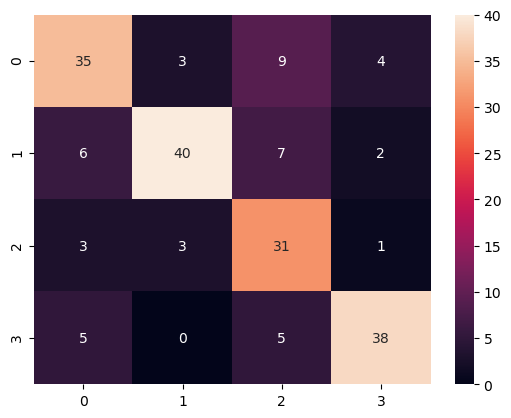

In [34]:
con_mlp_df=pd.DataFrame(con_matrix_mlp)
print("                               MLP")
sns.heatmap(con_mlp_df , annot= True)

                               KNN


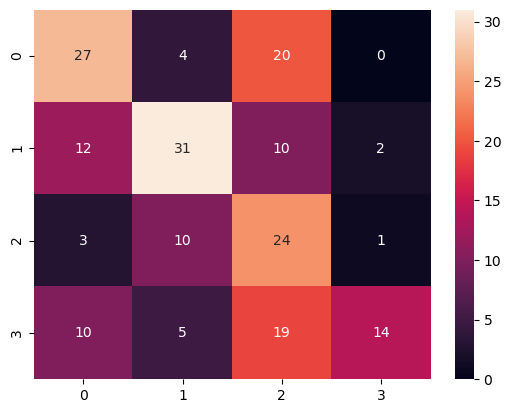

In [35]:
con_knn_df=pd.DataFrame(con_matrix_knn)
sns.heatmap(con_knn_df , annot= True)
print("                               KNN")

                               NAIVE BAYES


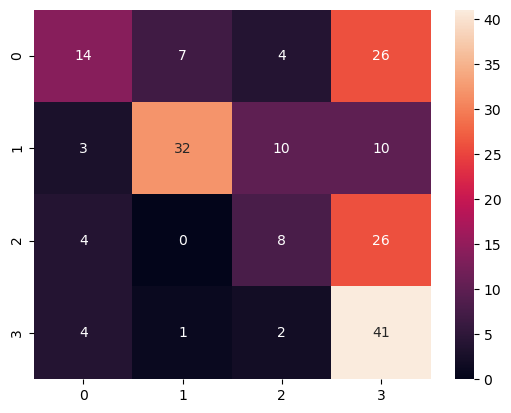

In [36]:
con_nb_df=pd.DataFrame(con_matrix_nb)
sns.heatmap(con_nb_df , annot= True)
print("                               NAIVE BAYES")

                          DECISION TREE


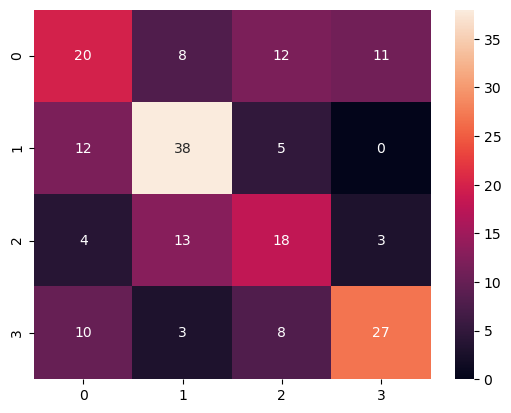

In [45]:
con_tree_df=pd.DataFrame(con_matrix_tree)
sns.heatmap(con_tree_df , annot= True)
print("                          DECISION TREE")

In [38]:

converted_y = lambda t: "happy" if t==1 else "angry" if  t==2 else "surprised" if t==3 else "sad" if t==4 else -1
convert_function = np.vectorize(converted_y)

y_test=convert_function(y_test)

y_pred_mlp = convert_function(y_pred_mlp)
y_pred_knn = convert_function(y_pred_knn)
y_pred_naivebayes = convert_function(y_pred_naivebayes)
y_pred_decisiontree = convert_function(y_pred_decisiontree)


Text(0.5, 1.0, 'F1')

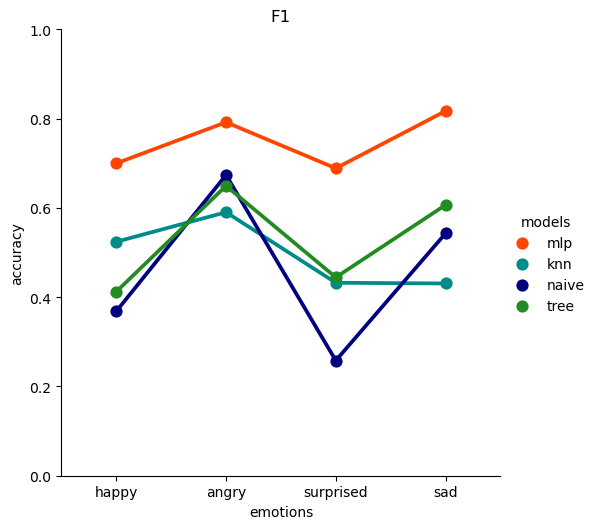

In [67]:
mlp = classification_report(y_test,y_pred_mlp,output_dict=True)
knn = classification_report(y_test,y_pred_knn,output_dict=True)
naive =classification_report(y_test,y_pred_naivebayes,output_dict=True)
tree =classification_report(y_test,y_pred_decisiontree,output_dict=True)
colors = ["orangered","darkcyan","navy","forestgreen"]
models = ["mlp","knn","naive","tree"]
dicti = {"models": [],
         "emotions": [],
         "accuracy": []}
    
modelss =[]
emotionss =[]
f1score = []
for model in models:
    for emo in observed_emotions:
        modelss.append(model)
        emotionss.append(emo)
        if model == "mlp":
            f1score.append(mlp[emo]["f1-score"])
        elif model == "knn":
            f1score.append(knn[emo]["f1-score"])
        elif model == "naive":
            f1score.append(naive[emo]["f1-score"])
        elif model == "tree":
            f1score.append(tree[emo]["f1-score"])


dicti["models"] = modelss
dicti["emotions"] = emotionss
dicti["accuracy"] = f1score


dfObjAcc = pd.DataFrame.from_dict(dicti, orient='columns')
sns.catplot(x="emotions",y = "accuracy", hue = "models", kind = "point", data = dfObjAcc,palette=colors);
plt.ylim(0,1)
plt.title("F1")

0.6862745098039216
0.7272727272727273
0.8157894736842105
0.7916666666666666
--------------
0.5294117647058824
0.5636363636363636
0.631578947368421
0.2916666666666667
--------------
0.27450980392156865
0.5818181818181818
0.21052631578947367
0.8541666666666666
--------------
0.39215686274509803
0.6909090909090909
0.47368421052631576
0.5625


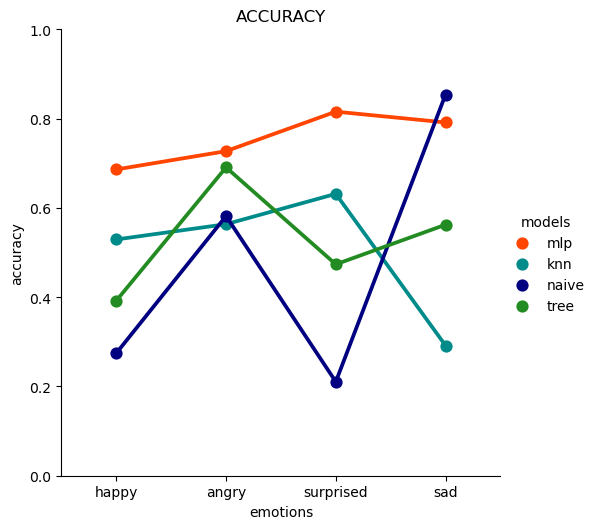

In [83]:
y_list = y_test.tolist()

mlp = [0,0,0,0]
knn = [0,0,0,0]
naive = [0,0,0,0]
decision = [0,0,0,0]
total =[0,0,0,0]

for i in range(len(y_list)):
    if(y_list[i] == "happy"):
        total[0] += 1
    if(y_list[i] == "angry"):
        total[1] += 1
    if(y_list[i] == "surprised"):
        total[2] += 1
    if(y_list[i] == "sad"):
        total[3] += 1
    if(y_list[i] == y_pred_mlp[i]):
        if(y_list[i] == "happy"):
            mlp[0] += 1
        if(y_list[i] == "angry"):
            mlp[1] += 1
        if(y_list[i] == "surprised"):
            mlp[2] += 1
        if(y_list[i] == "sad"):
            mlp[3] += 1
    if(y_list[i] == y_pred_knn[i]):
        if(y_list[i] == "happy"):
            knn[0] += 1
        if(y_list[i] == "angry"):
            knn[1] += 1
        if(y_list[i] == "surprised"):
            knn[2] += 1
        if(y_list[i] == "sad"):
            knn[3] += 1
    if(y_list[i] == y_pred_naivebayes[i]):
        if(y_list[i] == "happy"):
            naive[0] += 1
        if(y_list[i] == "angry"):
            naive[1] += 1
        if(y_list[i] == "surprised"):
            naive[2] += 1
        if(y_list[i] == "sad"):
            naive[3] += 1
    if(y_list[i] == y_pred_decisiontree[i]):
        if(y_list[i] == "happy"):
            decision[0] += 1
        if(y_list[i] == "angry"):
            decision[1] += 1
        if(y_list[i] == "surprised"):
            decision[2] += 1
        if(y_list[i] == "sad"):
            decision[3] += 1
            
            
colors = ["orangered","darkcyan","navy","forestgreen"]
models = ["mlp","knn","naive","tree"]
dicti = {"models": [],
         "emotions": [],
         "accuracy": []}
    
modelss =[]
emotionss =[]
accuracy = []

for model in models:
    for i in range(0,len(observed_emotions)):
        modelss.append(model)
        emotionss.append(observed_emotions[i])
        if model == "mlp":
            accuracy.append(mlp[i]/total[i])
        elif model == "knn":
            accuracy.append(knn[i]/total[i])
        elif model == "naive":
            accuracy.append(naive[i]/total[i])
        elif model == "tree":
            accuracy.append(decision[i]/total[i])


dicti["models"] = modelss
dicti["emotions"] = emotionss
dicti["accuracy"] = accuracy


dfObjAcc = pd.DataFrame.from_dict(dicti, orient='columns')
sns.catplot(x="emotions",y = "accuracy", hue = "models", kind = "point", data = dfObjAcc,palette=colors);
plt.ylim(0,1)
plt.title("ACCURACY")


for i in range(0,4):
    print(mlp[i]/total[i])
print('--------------')
for i in range(0,4):
    print(knn[i]/total[i])
print('--------------')
for i in range(0,4):
    print(naive[i]/total[i])
print('--------------')
for i in range(0,4):
    print(decision[i]/total[i])

51 55 38 0
HAPPY COUNT: 51
ANGRY COUNT 55
SURPRISED COUNT 38
NEUTRAL COUNT 0


Text(0.5, 1.0, 'MODELS ERROR COUNT')

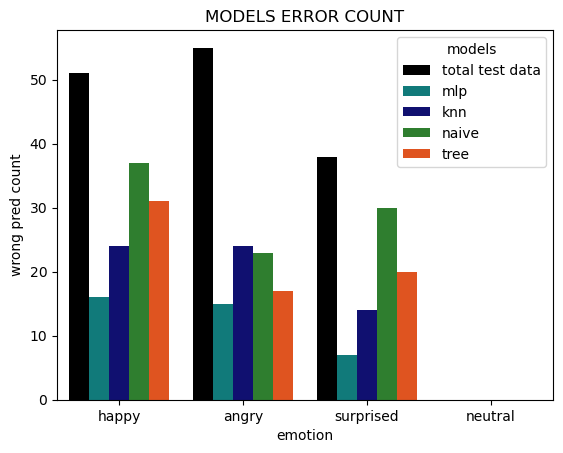

In [40]:
models =["mlp","knn","naive","tree"]
emotion = ["happy","angry","surprised","neutral"]
dic = {"models": [],
        "emotion": [],
        "wrong pred count": []}



modelss=[]
wrong = []
emotions =[]


#test verisini gruplayıp tabloya ekleme
test_happy_count=0
test_angry_count=0
test_surprised_count=0
test_neutral_count=0

for j in y_test:
    if j=="happy":
        test_happy_count +=1
    elif j=="angry":
        test_angry_count +=1
    elif j=="surprised":
        test_surprised_count +=1
    elif j=="neutral":
        test_neutral_count +=1
        
for emo in emotion:
    modelss.append("total test data")
    emotions.append(emo)
    if emo=="happy":
        wrong.append(test_happy_count)
    elif emo=="angry":
        wrong.append(test_angry_count)
    elif emo=="surprised":
        wrong.append(test_surprised_count)
    elif emo=="neutral":
        wrong.append(test_neutral_count)
print
print(test_happy_count,test_angry_count,test_surprised_count,test_neutral_count)

mlp_wrong_happy=0
mlp_wrong_angry=0
mlp_wrong_surprised=0
mlp_wrong_neutral=0

knn_wrong_happy=0
knn_wrong_angry=0
knn_wrong_surprised=0
knn_wrong_neutral=0

nb_wrong_happy=0
nb_wrong_angry=0
nb_wrong_surprised=0
nb_wrong_neutral=0

tree_wrong_happy=0
tree_wrong_angry=0
tree_wrong_surprised=0
tree_wrong_neutral=0


    

for m in models:
    for emo in emotion:
        if m=="mlp":
            modelss.append(m)
            emotions.append(emo)
            if m=="mlp":
                if emo=="happy":
                    for i in range(0,len(y_test)-1):
                        if y_test[i]=="happy":
                            if y_test[i]!=y_pred_mlp[i]:
                                mlp_wrong_happy +=1
                    wrong.append(mlp_wrong_happy)
                elif emo=="angry":
                    for i in range(0,len(y_test)-1):
                        if y_test[i]=="angry":
                            if y_test[i]!=y_pred_mlp[i]:
                                mlp_wrong_angry +=1
                    wrong.append(mlp_wrong_angry)
                elif emo=="surprised":
                    for i in range(0,len(y_test)-1):
                        if y_test[i]=="surprised":
                            if y_test[i]!=y_pred_mlp[i]:
                                mlp_wrong_surprised +=1
                    wrong.append(mlp_wrong_surprised)
                elif emo=="neutral":
                    for i in range(0,len(y_test)-1):
                        if y_test[i]=="neutral":
                            if y_test[i]!=y_pred_mlp[i]:
                                mlp_wrong_neutral +=1
                    wrong.append(mlp_wrong_neutral)  
                    
        elif m=="knn":
            modelss.append(m)
            emotions.append(emo)
            if emo=="happy":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="happy":
                        if y_test[i]!=y_pred_knn[i]:
                            knn_wrong_happy +=1
                wrong.append(knn_wrong_happy)
            elif emo=="angry":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="angry":
                        if y_test[i]!=y_pred_knn[i]:
                            knn_wrong_angry +=1
                wrong.append(knn_wrong_angry)
            elif emo=="surprised":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="surprised":
                        if y_test[i]!=y_pred_knn[i]:
                            knn_wrong_surprised +=1
                wrong.append(knn_wrong_surprised)
            elif emo=="neutral":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="neutral":
                        if y_test[i]!=y_pred_knn[i]:
                            knn_wrong_neutral +=1
                wrong.append(knn_wrong_neutral)
                        
        elif m=="naive":
            modelss.append(m)
            emotions.append(emo)
            if emo=="happy":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="happy":
                        if y_test[i]!=y_pred_naivebayes[i]:
                            nb_wrong_happy +=1
                wrong.append(nb_wrong_happy)
            elif emo=="angry":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="angry":
                        if y_test[i]!=y_pred_naivebayes[i]:
                            nb_wrong_angry +=1
                wrong.append(nb_wrong_angry)
            elif emo=="surprised":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="surprised":
                        if y_test[i]!=y_pred_naivebayes[i]:
                            nb_wrong_surprised +=1
                wrong.append(nb_wrong_surprised)
            elif emo=="neutral":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="neutral":
                        if y_test[i]!=y_pred_naivebayes[i]:
                            nb_wrong_neutral +=1
                wrong.append(nb_wrong_neutral)
            
        elif m=="tree":
            modelss.append(m)
            emotions.append(emo)
            if emo=="happy":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="happy":
                        if y_test[i]!=y_pred_decisiontree[i]:
                            tree_wrong_happy +=1
                wrong.append(tree_wrong_happy)
            elif emo=="angry":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="angry":
                        if y_test[i]!=y_pred_decisiontree[i]:
                            tree_wrong_angry +=1
                wrong.append(tree_wrong_angry)
            elif emo=="surprised":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="surprised":
                        if y_test[i]!=y_pred_decisiontree[i]:
                            tree_wrong_surprised +=1
                wrong.append(tree_wrong_surprised)
            elif emo=="neutral":
                for i in range(0,len(y_test)-1):
                    if y_test[i]=="neutral":
                        if y_test[i]!=y_pred_decisiontree[i]:
                            tree_wrong_neutral +=1
                wrong.append(tree_wrong_neutral)


        
dic["models"] = modelss
dic["wrong pred count"] = wrong
dic["emotion"] = emotions



dfObj = pd.DataFrame.from_dict(dic, orient='columns')
colors = ["black","darkcyan","navy","forestgreen","orangered"]
print("HAPPY COUNT:",test_happy_count)
print("ANGRY COUNT",test_angry_count)
print("SURPRISED COUNT",test_surprised_count)
print("NEUTRAL COUNT",test_neutral_count)
sns.barplot(x="emotion", y="wrong pred count",hue="models", data=dfObj,palette=colors,errwidth =1)
plt.title("MODELS ERROR COUNT")

,err_types,models,mean error
0,mean absolute error,mlp,0.416667
1,mean absolute error,knn,0.760417
2,mean absolute error,naive,0.916667
3,mean absolute error,tree,0.781250
4,mean squre error,mlp,0.843750
5,mean squre error,knn,1.385417
6,mean squre error,naive,2.052083
7,mean squre error,tree,1.635417


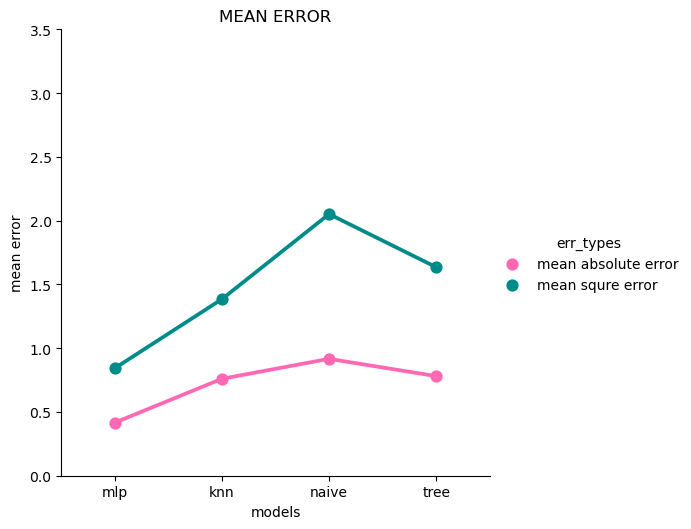

In [84]:
absoluteerr = [mlp_abs_err,knn_abs_err,naive_abs_err,tree_abs_err]
squareerr = [mlp_sqr_err,knn_sqr_err,naive_sqr_err,tree_sqr_err]

colors = ["hotpink","darkcyan"]
errtypes = ["mean absolute error","mean squre error"]
models = ["mlp","knn","naive","tree"]

dictimeanerror = {"err_types": [],
                    "models": [],
                    "mean error": []}

errtypess =[]
modelss =[]
meanerr = []

for ertyp in errtypes:
    for model in models:
        errtypess.append(ertyp)
        modelss.append(model)
        if ertyp =="mean absolute error":
            if model == "mlp":
                meanerr.append(absoluteerr[0])
            elif model == "knn":
                meanerr.append(absoluteerr[1])
            elif model == "naive":
                meanerr.append(absoluteerr[2])
            elif model == "tree":
                meanerr.append(absoluteerr[3])   
        elif ertyp =="mean squre error":
            if model =="mlp":
                meanerr.append(squareerr[0])
            elif model == "knn":
                meanerr.append(squareerr[1])
            elif model == "naive":
                meanerr.append(squareerr[2])
            elif model == "tree":
                meanerr.append(squareerr[3])

        


dictimeanerror["err_types"] = errtypess
dictimeanerror["models"] = modelss
dictimeanerror["mean error"] = meanerr
dictimeanerror
df_abs_sqr = pd.DataFrame.from_dict(dictimeanerror, orient='columns')
sns.catplot(x="models",y = "mean error", hue = "err_types", kind = "point", data = df_abs_sqr,palette=colors)
plt.ylim(0,3.5)
plt.title("MEAN ERROR")
df_abs_sqr

Text(0.5, 1.0, 'SENSİTİVİTY AND SPECİFİTY')

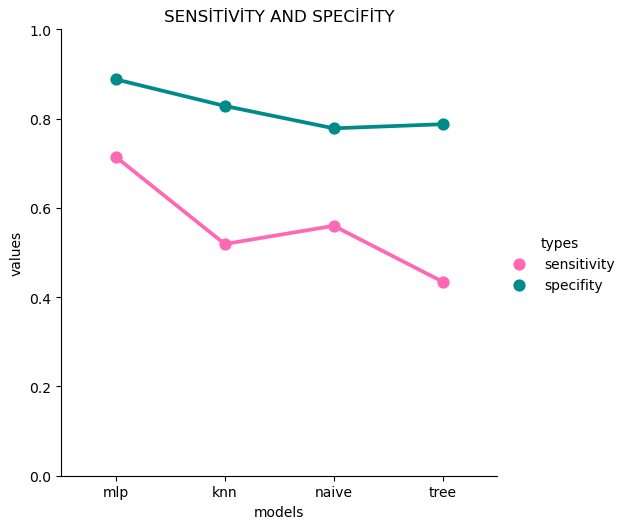

In [42]:
sensitivity = [mlp_sensitivity,knn_sensitivity,naivebayes_sensitivity,tree_sensitivity]
specifity = [mlp_specificity,knn_specificity,naivebayes_specificity,tree_specificity]

colors = ["hotpink","darkcyan"]
types = ["sensitivity","specifity"]
models = ["mlp","knn","naive","tree"]

dicti_sens_spec = {"types": [],
                    "models": [],
                    "values": []}

typess =[]
modelss =[]
valuess = []

for tp in types:
    for model in models:
        typess.append(tp)
        modelss.append(model)
        if tp =="sensitivity":
            if model == "mlp":
                valuess.append(sensitivity[0])
            elif model == "knn":
                valuess.append(sensitivity[1])
            elif model == "naive":
                valuess.append(sensitivity[2])
            elif model == "tree":
                valuess.append(sensitivity[3])   
        elif tp =="specifity":
            if model =="mlp":
                valuess.append(specifity[0])
            elif model == "knn":
                valuess.append(specifity[1])
            elif model == "naive":
                valuess.append(specifity[2])
            elif model == "tree":
                valuess.append(specifity[3])

        


dicti_sens_spec["types"] = typess
dicti_sens_spec["models"] = modelss
dicti_sens_spec["values"] = valuess
dicti_sens_spec
df_sens_spec = pd.DataFrame.from_dict(dicti_sens_spec, orient='columns')
sns.catplot(x="models",y = "values", hue = "types", kind = "point", data = df_sens_spec,palette=colors);
plt.ylim(0,1)
plt.title("SENSİTİVİTY AND SPECİFİTY")

                                      PRECİSİON


Text(0.5, 1.0, 'PRECİSİON')

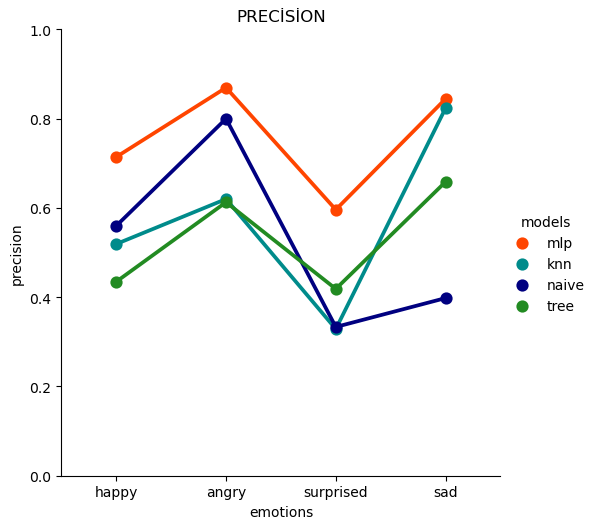

In [43]:
mlp = classification_report(y_test,y_pred_mlp,output_dict=True)
knn = classification_report(y_test,y_pred_knn,output_dict=True)
naive =classification_report(y_test,y_pred_naivebayes,output_dict=True)
tree =classification_report(y_test,y_pred_decisiontree,output_dict=True)

colors = ["orangered","darkcyan","navy","forestgreen"]
models = ["mlp","knn","naive","tree"]
dicti_precision = {"models": [],
         "emotions": [],
         "precision": []}
    
modelss =[]
emotionss =[]
precisionss = []
for model in models:
    for emo in observed_emotions:
        modelss.append(model)
        emotionss.append(emo)
        if model == "mlp":
            precisionss.append(mlp[emo]["precision"])
        elif model == "knn":
            precisionss.append(knn[emo]["precision"])
        elif model == "naive":
            precisionss.append(naive[emo]["precision"])
        elif model == "tree":
            precisionss.append(tree[emo]["precision"])


dicti_precision["models"] = modelss
dicti_precision["emotions"] = emotionss
dicti_precision["precision"] = precisionss

dicti_precision
dfObjPrec = pd.DataFrame.from_dict(dicti_precision, orient='columns')
print("                                      PRECISION")
sns.catplot(x="emotions",y = "precision", hue = "models", kind = "point", data = dfObjPrec,palette=colors);
plt.ylim(0,1)
plt.title("PRECISION")

Text(0.5, 1.0, 'RECALL')

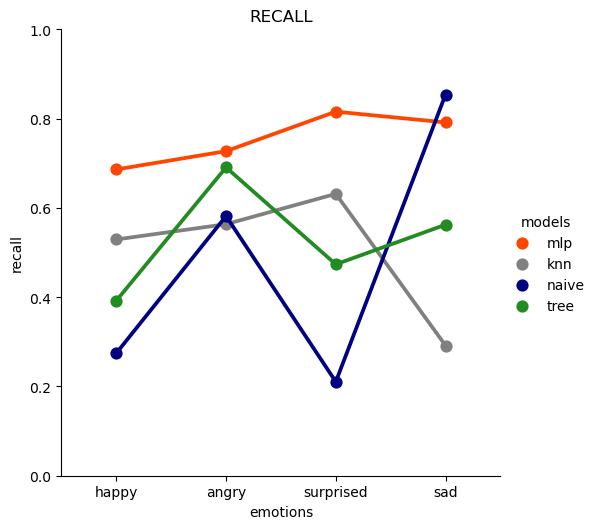

In [44]:
mlp = classification_report(y_test,y_pred_mlp,output_dict=True)
knn = classification_report(y_test,y_pred_knn,output_dict=True)
naive =classification_report(y_test,y_pred_naivebayes,output_dict=True)
tree =classification_report(y_test,y_pred_decisiontree,output_dict=True)

colors = ["orangered","gray","navy","forestgreen"]
models = ["mlp","knn","naive","tree"]
dicti_recall = {"models": [],
         "emotions": [],
         "recall": []}
    
modelss =[]
emotionss =[]
recallss = []
for model in models:
    for emo in observed_emotions:
        modelss.append(model)
        emotionss.append(emo)
        if model == "mlp":
            recallss.append(mlp[emo]["recall"])
        elif model == "knn":
            recallss.append(knn[emo]["recall"])
        elif model == "naive":
            recallss.append(naive[emo]["recall"])
        elif model == "tree":
            recallss.append(tree[emo]["recall"])


dicti_recall["models"] = modelss
dicti_recall["emotions"] = emotionss
dicti_recall["recall"] = recallss

dicti_recall
dfObjPrec = pd.DataFrame.from_dict(dicti_recall, orient='columns')
sns.catplot(x="emotions",y = "recall", hue = "models", kind = "point", data = dfObjPrec,palette=colors)
plt.ylim(0,1)
plt.title("RECALL")